Load data set 

In [1]:
import numpy as np
import pickle
import os
import sys
import urllib.request
import tarfile
import zipfile

#######################################################################
def _print_download_progress(count, block_size, total_size):
    """ Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract(). """
    # Percentage completion.
    pct_complete = float(count * block_size) / total_size
    # Limit it because rounding errors may cause it to exceed 100%.
    pct_complete = min(1.0, pct_complete)
    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

cifar10_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "cifar-10/"
data_path = "cifar-10/"

# Filename for saving the file downloaded from the internet.
# Use the filename from the URL and add it to the download_dir.
filename = cifar10_url.split('/')[-1]
file_path = os.path.join(download_dir, filename)

# Check if the file already exists.
# If it exists then we assume it has also been extracted,
# otherwise we need to download and extract it now.
if not os.path.exists(file_path):
    # Check if the download directory exists, otherwise create it.
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    # Download and extract the dataset
    # Download the file from the internet.
    file_path, _ = urllib.request.urlretrieve(url=cifar10_url,
                                          filename=file_path,
                                          reporthook=_print_download_progress)
    print()
    print("Download finished. Extracting files.")

    if file_path.endswith(".zip"):
        # Unpack the zip-file.
        zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
    elif file_path.endswith((".tar.gz", ".tgz")):
        # Unpack the tar-ball.
        tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

    print("Done.")
else:
    print("Data has apparently already been downloaded and unpacked.")

Data has apparently already been downloaded and unpacked.


In [2]:
import tensorflow as tf
import numpy

cifar10_path = os.path.join(data_path, "cifar-10-batches-py/")

#############################################################################
def load_images(file_path):
    # Read images from data set
    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding, otherwise an exception is raised here.
        # Loading the data from pickle file
        data = pickle.load(file, encoding='bytes')
        # get the raw images
        raw_images = data[b'data']
        # get the class numbers for each image, convert to numpy array
        labels = np.array(data[b'labels'])
        # Convert the raw images from the data-files to floating-points.
        raw_float = np.array(raw_images, dtype=float) / 255.0
        # Reshape the array to 4-dimensions.
        images = raw_float.reshape([-1, 3, 32, 32])
        # Reorder the indices of the array.
        images = images.transpose([0, 2, 3, 1])

    return images, labels

#############################################################################
def load_data(data_path):
    num_images = 10000
    x = 0
    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    x_train = np.zeros(shape=[40000, 32, 32, 3], dtype=float)
    y_train = np.zeros(shape=[40000], dtype=int)
    # attach the filename to directory
    train_path = os.path.join(data_path, "data_batch_1")
    x_train[x: x + num_images, :], y_train[x: x + num_images] = load_images(train_path)
    x = x + num_images
    
    train_path = os.path.join(data_path, "data_batch_2")
    x_train[x: x + num_images, :], y_train[x: x + num_images] = load_images(train_path)
    x = x + num_images
    
    train_path = os.path.join(data_path, "data_batch_3")
    x_train[x: x + num_images, :], y_train[x: x + num_images] = load_images(train_path)
    x = x + num_images
    
    train_path = os.path.join(data_path, "data_batch_4")
    x_train[x: x + num_images, :], y_train[x: x + num_images] = load_images(train_path)
    
    validation_path = os.path.join(data_path, "data_batch_5")
    x_validation, y_validation = load_images(validation_path)
    
    test_path = os.path.join(data_path, "test_batch")
    x_test, y_test = load_images(test_path)

    return x_train, y_train, x_validation, y_validation, x_test, y_test    

X_train, y_train, X_validation, y_validation, X_test, y_test = load_data(cifar10_path)

# Resize images to 224x224x3 for AlexNet
# X_train      = numpy.ndarray(tf.image.resize_images(X_train, [224, 224]))
# X_validation = numpy.ndarray(tf.image.resize_images(X_validation, [224, 224]))
# X_test       = numpy.ndarray(tf.image.resize_images(X_test, [224, 224]))

# Print image data set parameters
print('Input Image shape: ', X_train[0].shape)
print("No. of training images: ", len(X_train))
print("No. of validation images: ", len(X_validation))
print("No. of testing images: ", len(X_test))


Input Image shape:  (32, 32, 3)
No. of training images:  40000
No. of validation images:  10000
No. of testing images:  10000


Pre-processing the input images

Visualize the data

2


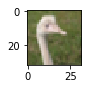

In [4]:
import random
import matplotlib.pyplot as plt
# select a random image
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
# plot the images
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

# pre-processing 
#from sklearn.utils import shuffle
#X_train, y_train = shuffle(X_train, y_train)

Implement AlexNet in Tensorflow

In [6]:
import tensorflow as tf

EPOCHS = 1
BATCH_SIZE = 64

epsilon = 1e-3

from tensorflow.contrib.layers import flatten

def AlexNet(x):    
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = . Output = .
    # conv1_kernel = tf.Variable(tf.truncated_normal(shape=(11, 11, 3, 96), mean = mu, stddev = sigma))
    conv1_kernel = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 96), mean = mu, stddev = sigma))
    conv1_bias   = tf.Variable(tf.zeros(96))
    # conv1_output = tf.nn.conv2d(x, conv1_kernel, strides=[1, 4, 4, 1], padding='SAME') + conv1_bias
    conv1_output = tf.nn.conv2d(x, conv1_kernel, strides=[1, 4, 4, 1], padding='SAME') + conv1_bias
    # Layer 1: Batch Normalization
    conv1_mean, conv1_var = tf.nn.moments(conv1_output, [0])
    conv1_scale = tf.Variable(tf.ones([96]))
    conv1_beta  = tf.Variable(tf.zeros([96]))
    conv1_batch_norm = tf.nn.batch_normalization(conv1_output, conv1_mean, conv1_var, conv1_beta, conv1_scale, epsilon)
    # Layer 1: Activation.
    conv1_act = tf.nn.relu(conv1_batch_norm)
    # Layer 1: Pooling. Input = . Output = .
    conv1_pool = tf.nn.max_pool(conv1_act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = . Output = .
    # conv2_kernel = tf.Variable(tf.truncated_normal(shape=(5, 5, 96, 256), mean = mu, stddev = sigma))
    conv2_kernel = tf.Variable(tf.truncated_normal(shape=(3, 3, 96, 256), mean = mu, stddev = sigma))
    conv2_bias   = tf.Variable(tf.zeros(256))
    conv2_output = tf.nn.conv2d(conv1_pool, conv2_kernel, strides=[1, 1, 1, 1], padding='SAME') + conv2_bias
    # Layer 2: Batch Normalization
    conv2_mean, conv2_var = tf.nn.moments(conv2_output, [0])
    conv2_scale = tf.Variable(tf.ones([256]))
    conv2_beta  = tf.Variable(tf.zeros([256]))
    conv2_batch_norm = tf.nn.batch_normalization(conv2_output, conv2_mean, conv2_var, conv2_beta, conv2_scale, epsilon)
    # Layer 2: Activation.
    conv2_act = tf.nn.relu(conv2_batch_norm)
    # Layer 2: Pooling. Input = . Output = .
    conv2_pool = tf.nn.max_pool(conv2_act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 3: Convolutional. Input = . Output = .
    conv3_kernel = tf.Variable(tf.truncated_normal(shape=(3, 3, 256, 384), mean = mu, stddev = sigma))
    conv3_bias   = tf.Variable(tf.zeros(384))
    conv3_output = tf.nn.conv2d(conv2_pool, conv3_kernel, strides=[1, 1, 1, 1], padding='SAME') + conv3_bias
    # Layer 3: Batch Normalization
    conv3_mean, conv3_var = tf.nn.moments(conv3_output, [0])
    conv3_scale = tf.Variable(tf.ones([384]))
    conv3_beta  = tf.Variable(tf.zeros([384]))
    conv3_batch_norm = tf.nn.batch_normalization(conv3_output, conv3_mean, conv3_var, conv3_beta, conv3_scale, epsilon)
    # Layer 3: Activation.
    conv3_act = tf.nn.relu(conv3_batch_norm)

    # Layer 4: Convolutional. Input = . Output = .
    conv4_kernel = tf.Variable(tf.truncated_normal(shape=(3, 3, 384, 384), mean = mu, stddev = sigma))
    conv4_bias   = tf.Variable(tf.zeros(384))
    conv4_output = tf.nn.conv2d(conv3_act, conv4_kernel, strides=[1, 1, 1, 1], padding='SAME') + conv4_bias
    # Layer 4: Batch Normalization
    conv4_mean, conv4_var = tf.nn.moments(conv4_output, [0])
    conv4_scale = tf.Variable(tf.ones([384]))
    conv4_beta  = tf.Variable(tf.zeros([384]))
    conv4_batch_norm = tf.nn.batch_normalization(conv4_output, conv4_mean, conv4_var, conv4_beta, conv4_scale, epsilon)
    # Layer 4: Activation.
    conv4_act = tf.nn.relu(conv4_batch_norm)

    # Layer 5: Convolutional. Input = . Output = .
    conv5_kernel = tf.Variable(tf.truncated_normal(shape=(3, 3, 384, 384), mean = mu, stddev = sigma))
    conv5_bias   = tf.Variable(tf.zeros(384))
    conv5_output = tf.nn.conv2d(conv4_act, conv5_kernel, strides=[1, 1, 1, 1], padding='SAME') + conv5_bias
    # Layer 5: Batch Normalization
    conv5_mean, conv5_var = tf.nn.moments(conv5_output, [0])
    conv5_scale = tf.Variable(tf.ones([384]))
    conv5_beta  = tf.Variable(tf.zeros([384]))
    conv5_batch_norm = tf.nn.batch_normalization(conv5_output, conv5_mean, conv5_var, conv5_beta, conv5_scale, epsilon)
    # Layer 5: Activation.
    conv5_act = tf.nn.relu(conv5_batch_norm)
    # Layer 5: Pooling. Input = . Output = .
    conv5_pool = tf.nn.max_pool(conv5_act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')    
    
    # Layer 6: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv5_pool)
    
    # Layer 7: Fully Connected. Input = 400. Output = 120.
    fc1_kernel = tf.Variable(tf.truncated_normal(shape=(384, 120), mean = mu, stddev = sigma))
    fc1_bias   = tf.Variable(tf.zeros(120))
    fc1_output = tf.matmul(fc0, fc1_kernel) + fc1_bias
    # Layer 7: Batch Normalization
    fc1_mean, fc1_var = tf.nn.moments(fc1_output, [0])
    fc1_scale = tf.Variable(tf.ones([120]))
    fc1_beta  = tf.Variable(tf.zeros([120]))
    fc1_batch_norm = tf.nn.batch_normalization(fc1_output, fc1_mean, fc1_var, fc1_beta, fc1_scale, epsilon)    
    # Layer 7: Activation.
    fc1_act = tf.nn.relu(fc1_batch_norm)
    # Layer 7: Drop out
    fc2_act = tf.nn.dropout(fc1_act, 0.5) 
    
    # Layer 8: Fully Connected. Input = 120. Output = 84.
    fc2_kernel = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_bias   = tf.Variable(tf.zeros(84))
    fc2_output = tf.matmul(fc1_act, fc2_kernel) + fc2_bias
    # Layer 8: Batch Normalization
    fc2_mean, fc2_var = tf.nn.moments(fc2_output, [0])
    fc2_scale = tf.Variable(tf.ones([84]))
    fc2_beta  = tf.Variable(tf.zeros([84]))
    fc2_batch_norm = tf.nn.batch_normalization(fc2_output, fc2_mean, fc2_var, fc2_beta, fc2_scale, epsilon)        
    # Layer 8: Activation.
    fc2_act = tf.nn.relu(fc2_batch_norm)
    # Layer 8: Drop out 
    fc2_act = tf.nn.dropout(fc2_act, 0.5) 
    
    # Layer X: Fully Connected. Input = 400. Output = 120.
    fc3_kernel = tf.Variable(tf.truncated_normal(shape=(84, 84), mean = mu, stddev = sigma))
    fc3_bias   = tf.Variable(tf.zeros(84))
    fc3_output = tf.matmul(fc2_act, fc3_kernel) + fc3_bias
    # Layer X: Batch Normalization
    fc3_mean, fc3_var = tf.nn.moments(fc3_output, [0])
    fc3_scale = tf.Variable(tf.ones([84]))
    fc3_beta  = tf.Variable(tf.zeros([84]))
    fc3_batch_norm = tf.nn.batch_normalization(fc3_output, fc3_mean, fc3_var, fc3_beta, fc3_scale, epsilon)    
    # Layer X: Activation.
    fc3_act = tf.nn.relu(fc3_batch_norm)
    # Layer X: Drop out
    fc3_act = tf.nn.dropout(fc3_act, 0.5) 
    
    # Layer 9: Fully Connected. Input = 84. Output = 10.
    fc4_kernel = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc4_bias   = tf.Variable(tf.zeros(10))
    logits     = tf.matmul(fc3_act, fc4_kernel) + fc4_bias
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)


Setup training pipeline

In [8]:
rate = 0.001

logits = AlexNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Setup Model evaluation pipeline

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Train the model

Note: Saves four files

1. checkpoint : 
2. lenet.data-0000-of-00001 : holding weights
3. lenet.index
4. lenet.meta : graph meta data for re-training

Also, saves frozen model as *.pb (binary) and *.pbtxt (human readable)

In [ ]:
from pathlib import Path

EPOCHS = 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    model_file = Path("model/AlexNet.ckpt.meta")
    if model_file.is_file():
        saver.restore(sess, 'model/AlexNet.ckpt')
        print("Loaded model from disk") 
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'model/AlexNet.ckpt')
    tf.train.write_graph(sess.graph.as_graph_def(), '.', 'model/AlexNet.pbtxt', as_text=True)
    tf.train.write_graph(sess.graph.as_graph_def(), '.', 'model/AlexNet.pb', as_text=False)
    print("Model saved")

INFO:tensorflow:Restoring parameters from model/AlexNet.ckpt


INFO:tensorflow:Restoring parameters from model/AlexNet.ckpt


Loaded model from disk
Training...



Save, restore and evaluate model

In [23]:
with tf.Session() as sess:
    saver.restore(sess, 'model/AlexNet.ckpt')
    #new_saver = tf.train.import_meta_graph('model/AlexNet.meta')
    #new_saver.restore(sess, tf.train.latest_checkpoint('model/'))
                
    validation_accuracy = evaluate(X_validation, y_validation)
    print("EPOCH {} ...".format(i+1))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print()
    
    saver.save(sess, 'model/AlexNet.ckpt')
    tf.train.write_graph(sess.graph.as_graph_def(), '.', 'model/AlexNet.pbtxt', as_text=True)
    tf.train.write_graph(sess.graph.as_graph_def(), '.', 'model/AlexNet.pb', as_text=False)
    
print("Model saved")

INFO:tensorflow:Restoring parameters from model/AlexNet.ckpt


INFO:tensorflow:Restoring parameters from model/AlexNet.ckpt


EPOCH 10 ...
Validation Accuracy = 0.605

Model saved


Evaluate Model

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('model/'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from model/AlexNet


INFO:tensorflow:Restoring parameters from model/AlexNet


Test Accuracy = 0.455
